TP5 : Programmation du K-NN et du perceptron
=======

Dans ce TP, nous allons principalement programmer un perceptron, et mettre en place une "architecture" de code nous permettant petit à petit de tester différents modèles d'apprentissage supervisé. Nous allons nous restreindre au cas binaire ou les données sont étiquetées $+1$ ou $-1$

In [1]:
import numpy as np
import pandas as pd


Information Utiles
======

* La concaténation de vecteurs s'obtient à l'aide de la fonction vstack de numpy

Etape 1: Dataset
------

La première étape consiste à définir une classe permettant de stocker les données d'apprentissage, de validation et de test. Nous considérerons que les données tiennent en mémoire. Nous allons définir une classe permettant de stocker des couples $\{(x_1,y_1),...,(x_n,y_n)\}$. Les $x_i$ et $y_i$ seront des tableaux numpy. 

In [2]:
class LabeledSet:  
    
    def __init__(self,input_dimension):
        self.input_dimension=input_dimension
        self.nb_examples=0
    
    def addExample(self,vector,label):
        if (self.nb_examples==0):
            self.x=np.array([vector])
            self.y=np.array([label])
        else:
            self.x=np.vstack((self.x,vector))
            self.y=np.vstack((self.y,label))
        self.nb_examples=self.nb_examples + 1
    
    #Renvoie la dimension de l'espace d'entrée
    def getInputDimension(self):
        return self.input_dimension
    
    
    #Renvoie le nombre d'exemple dans le set
    def size(self):
        return self.nb_examples
    
    #Renvoie la valeur de x_i
    def getX(self,i):
        return self.x[i]
        
    
    #Renvoie la valeur de y_i
    def getY(self,i):
        return(self.y[i])
       
  

        

Génération de données ''Jouet''
====

Nous allons pour l'instant nous intéresser à des datasets "jouet" générés selon des distributions choisies à la main. Commençons par un dataset en 2 dimensions (entrée) et 1 dimension (sortie): $x_i \in \mathbb{R}^2$, $y_i \in [-1;+1]$ telles que les données sont généres selon deux Gaussiennes. Pour cela, nous utiliserons la fonction numpy.random.multivariate_normal  - http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multivariate_normal.html 

* ''positive_center'' est le centre de la gaussienne des points positifs (vecteur de taille 2)
* ''positive_sigma'' est la variance de la gaussienne (sous forme de matrice 2*2)
* Idem pour ''negative''

* Générer une premiere gaussienne associée au label $+1$
* Y rajouter une seconde gaussienne associée au label $-1$


In [3]:
def createGaussianDataset(positive_center,positive_sigma,negative_center,negative_sigma,nb_points):
        l=LabeledSet(2)
        positive_points=np.random.multivariate_normal(positive_center,positive_sigma,nb_points)
        for i in range(nb_points):
            l.addExample(positive_points[i],1)
        negative_points=np.random.multivariate_normal(negative_center,negative_sigma,nb_points)
        for i in range(nb_points):
            l.addExample(negative_points[i],-1)
        
        return(l)
    
the_set=createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),100)
print(the_set.size())

200


Le dataset peut être affiché en utilisant matplotlib (pour vérifier). Nous utiliserons la commande matplotlib.pyplot.scatter permettant de dessiner un nuage de points - http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter -

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 

def plot2DSet(the_set,c='blue'):
    pointsPositifs = np.array([0,0])
    pointsNegatifs =np.array([0,0])
    for i in range(the_set.size()):
        ligne = the_set.getX(i)
        if(the_set.getY(i)[0] == 1):
              pointsPositifs = np.vstack((pointsPositifs,ligne))
        else :
            pointsNegatifs = np.vstack((pointsNegatifs,ligne))
    pp=plt.scatter(pointsPositifs[1: , 0],pointsPositifs[1:,1],marker='o',color=c, alpha=0.8)
    pn=plt.scatter(pointsNegatifs[1: , 0],pointsNegatifs[1:,1],marker='x',color=c, alpha=0.8)
    plt.legend((pp,pn),('label 1', 'label -1'),loc='lower left',scatterpoints=1, ncol=2,fontsize=8)
    plt.title("Tracer un nuage de points ")
    plt.xlabel("x")
    plt.ylabel("y")


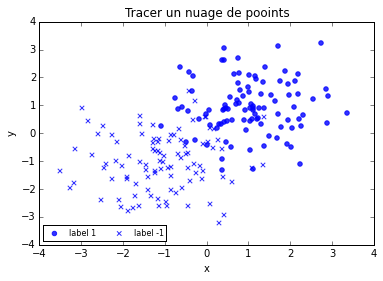

In [125]:
plot2DSet(the_set)

Les classifieurs
====

Un classifieur (binaire) permet, pour chaque point d'entrée, de calculer un score. Si le score est négatif, la donnée est associée à la classe $-1$ et à la classe $+1$ sinon. Commençons par définir une classe permettant par la suite de définir plusieurs classifieurs.

* Pour l'instant les méthodes ''train'' et ''predict'' ne seront pas définies car elles dépendent du modèle
* La fonction computeAccuracy renvoie le pourcentage de points bien classés. Elle peut être définie dès maintenant

In [5]:
class Classifier:
    def __init__(self,input_dimension):
         self.input_dimension=input_dimension
    
    
    #Permet de calculer la prediction sur x => renvoie un label
    def predict(self,x):
        raise NotImplementedError("Please Implement this method")

    
    #Permet d'entrainer le modele sur un ensemble de données
    def train(self,labeledSet):
        raise NotImplementedError("Please Implement this method")
    
    #Permet de calculer la qualité du système 
    def accuracy(self,set):
        tabY = np.zeros(set.size())
        tabYpredit = np.zeros(set.size())
        n=0
        for i in range(set.size()):
            tabYpredit[i] = self.predict(set.getX(i))
            tabY[i] = set.getY(i)[0]
            if( tabYpredit[i] ==  tabY[i]) :
                n = n + 1
        return float(n)/ set.size()  

16


Nous allons maintenant définir un classifieur linéaire aléatoire :
* la fonction ''predict'' renvoie la valeur de $<w;x>$ ou $w$ est un vecteur (de taille ''input_dimension'') tiré aléatoirement à la construction du classifieur

In [6]:
class ClassifierRandom(Classifier):
    def __init__(self,input_dimension):
        self.input_dimension=input_dimension
        self.w = np.random.randn(input_dimension)
    #Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        if (0<np.sum(self.w*x)):
            return 1
        else :
            return -1
    
    #Permet d'entrainer le modele sur un ensemble de données
    def train(self,labeledSet):
        print("No training needed")

Nous allons calculer la performance (''accuracy'') du classifieur random sur un ensemble de 100 points

In [7]:
classifieur_random=ClassifierRandom(2)
print(classifieur_random.accuracy(the_set))

0.1


Voici une fonction qui permet de dessiner la frontière de décision d'un classifieur. La valeur 'step' permet de choisir la précision du dessin

0.345


/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


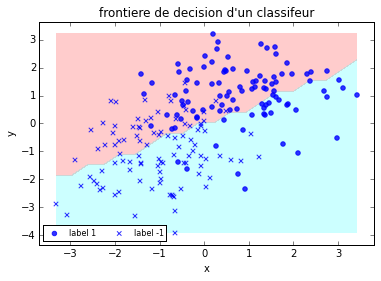

In [8]:
def  plot_frontiere(set,classifier,step=20):
    mmax=set.x.max(0)
    mmin=set.x.min(0)
    x1grid,x2grid=np.meshgrid(np.linspace(mmin[0],mmax[0],step),np.linspace(mmin[1],mmax[1],step))
    grid=np.hstack((x1grid.reshape(x1grid.size,1),x2grid.reshape(x2grid.size,1)))
    
    # calcul de la prediction pour chaque point de la grille
    res=np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res=res.reshape(x1grid.shape)
    # tracer des frontieres
    plt.contourf(x1grid,x2grid,res,colors=["red","cyan"],levels=[-1000,0,1000],linewidth=2,alpha=0.2)

classifieur_random=ClassifierRandom(2)

the_set=createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),100)
plot_frontiere(the_set,classifieur_random)
plot2DSet(the_set)
plt.title("frontiere de decision d'un classifeur ")
print(classifieur_random.accuracy(the_set))

Le k-nn
--------

Définissez le classifieur K-NN. Pour cela nous allons construire un tableau de distance que nous trirons grâce à la méthode numpy.argsort

1.0


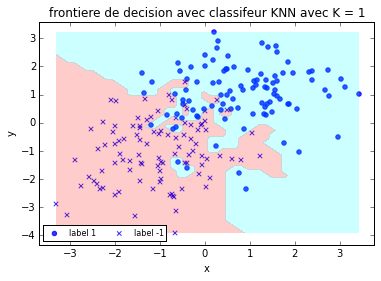

In [21]:
import math
class KNN(Classifier):
    def __init__(self,input_dimension,k):
        self.input_dimension = input_dimension
        self.k = k
    #Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        # Calculer le tableau des distances entre x et les points du set
        points = self.set.x
        tabDist = np.zeros(len(points))
        for i in range(len(points)):
            tabDist[i] = math.sqrt(((x[0]-points[i][0])**2)+((x[1]-points[i][1])**2))
        #Tri
        index = np.argsort(tabDist)
        nb1 = 0
        nb2 = 0
        for i in range(self.k) :
            if(self.set.getY(index[i]) == -1):
                nb1 += 1
            else:
                nb2 += 1
        if nb1 > nb2:
            return -1
        else:
            return 1
    
    #Permet d'entrainer le modele sur un ensemble de données, ici : indique le set à utiliser dans la fonction predict
    def train(self,set):
        self.set=set
         
knn=KNN(2,1)
knn.train(the_set)

plot2DSet(the_set)
plot_frontiere(the_set,knn,50)
plt.title("frontiere de decision avec classifeur KNN avec K = 1 ")
print(knn.accuracy(the_set))

In [180]:
np.array([0,0])

array([0, 0])

Protocole expérimental
=====

Attention, lorsque vous testez un classifieur, il est nécessaire de considérer à la fois un ensemble d'apprentissage et un ensemble de test. La performance doit être évaluée sur l'ensemble de test (et non pas sur l'ensemble d'évaluation)

Accuracy on train 1.000000
Accuracy on test 0.850000


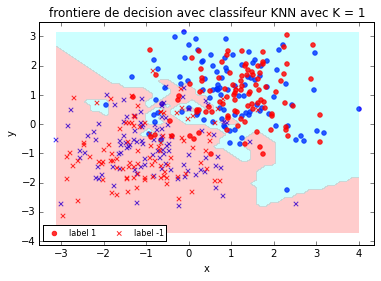

In [22]:
train_set=createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),100)
test_set=createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),100)

knn=KNN(2,1)
knn.train(train_set)
print("Accuracy on train %f" % knn.accuracy(train_set))
print("Accuracy on test %f" % knn.accuracy(test_set))
plot2DSet(train_set)
plot_frontiere(train_set,knn,50)

#les croix et les ronds en rouge ==> test_set
plot2DSet(test_set,c='red')
plt.title("frontiere de decision avec classifeur KNN avec K = 1")
plt.show()

Travail libre
====

* Comparer la performance (en train et test) de plusieurs classifieurs KNN avec différentes valeurs de k. Que pouvez vous constater
* * Idéalement, vous tracerez la performance (accuracy) en fonction de la valeur de k
* Essayez avec différentes configurations de gausiennes


In [113]:
def CourbePerformanceKnn(trainSet,testSet,n) :
    tabTrain = np.zeros(n)
    tabTest = np.zeros(n)
    valeurK = range(n)
    for i in valeurK :
        knn=KNN(2,i)
        knn.train(trainSet)
        tabTrain[i] = knn.accuracy(trainSet)
        tabTest[i] = knn.accuracy(testSet)
    plt.plot(valeurK,tabTrain)
    plt.plot(valeurK,tabTest)
    plt.legend(['Apprentissage','test'],loc= 'lower left', ncol=2)
    plt.title("Courbe de performance (accuracy) pour les donnees d'entrainement et les donnees de test pour K differents")
    plt.xlabel("K")
    plt.ylabel("Accuracy")
    plt.show()
    

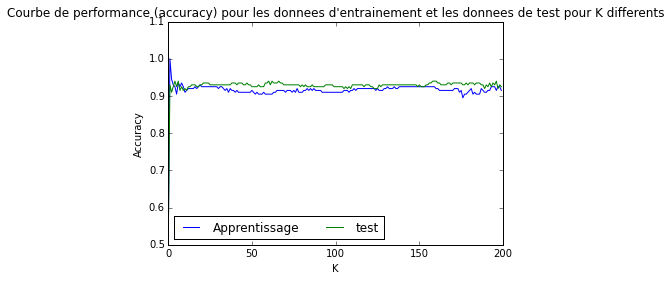

In [114]:
train_set=createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),100)
test_set=createGaussianDataset(np.array([1,1]),np.array([[1,0],[0,1]]),np.array([-1,-1]),np.array([[1,0],[0,1]]),100)
n = 200
CourbePerformanceKnn(train_set,test_set,n) 


Expérimentation : UCI
-----

Plusieurs datasets sont téléchargeables depuis:  http://mldata.org

Voici la fonction permettant de les charger (name spécifiant leur nom). La fonction se charge de télécharger les données depuis le Web

In [65]:
from sklearn.datasets import fetch_mldata

def loadFile(name):
    data = fetch_mldata(name, data_home='.')
    print(data.data.shape)
    unique=np.unique(data.target)
    for i in range(len(data.target)):
        if (data.target[i]==unique[0]):
            data.target[i]=1
        else:
            data.target[i]=-1
    return data       
d=loadFile('breast-cancer_scale')
#Les donnees sont dans data.data et data.target


(683, 10)


Ecrire la fonction de split permettant de découper les données en un ensemble d'apprentissage et un ensemble de test

In [55]:
def split(set):
    trainSet = LabeledSet(len(set.data[0]))
    testSet = LabeledSet(len(set.data[0]))
    ind = int(math.ceil(len(set.data)/2))
    for i in range(ind):
        trainSet.addExample(set.data[i],set.target[i])
    for j in range(ind,len(set.data)):
        testSet.addExample(set.data[j],set.target[j])
    return trainSet,testSet


In [64]:
trainSet,testSet = split(d)
print(trainSet.x.shape)
print(testSet.x.shape)

(341, 10)
(342, 10)


Testez différents k-NN , pour k différents, et tracez la courbe de performance (accuracy) pour les données d'entraînement et les données de test

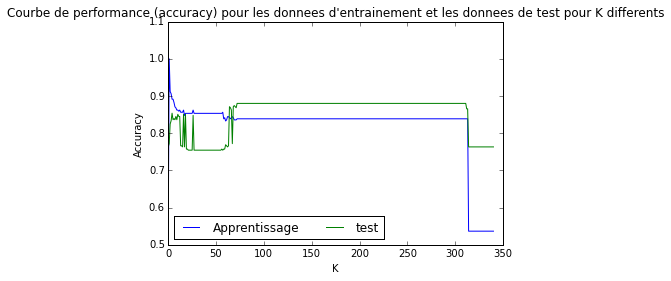

In [115]:
 CourbePerformanceKnn(trainSet,testSet,trainSet.size())